# Volume 4: Stochastic Differential Equations

# Kameron Lightheart
# MATH 437
# 12/5/19

In [21]:
"""Volume 4. Stochastic Differential Equations."""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy import linalg as la

In [26]:
def animate(X, U, title):
    # turn off display while rendering
    plt.ioff()    
    n = U.shape[0] 
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))    
    # create the lines for the heat distribution
    solution, = plt.plot([], [], color='b', label='solution')    
    def update(i):
        # At each frame update the plot
        solution.set_data(X, U[i,:])        
        return solution    
    
    # here we plot and animate the plot
    plt.legend()
    animation.writer = animation.writers['ffmpeg']
    plt.title('Animation of Solution to Wave Equation')
    ani = animation.FuncAnimation(fig, update, frames=range(n), interval=100)
    ani.save(f'{title}.mp4')
    plt.ion()
    plt.close()

In [37]:
# Problem 1
def brownian_motion(g,y0,t):
    """
    Use the concepts of Brownian motion to
    generate animation of particle randomly moving
    
    Parameters:
        g (func): scalar function
        y0 (ndarray (2,)): inital condition
        t (ndarray): time points
    """
    # Initialize empty solution array
    sol = np.zeros((len(t), len(y0)))
    # Set the first element of 
    sol[0] = y0
    for i in range(1, len(t-1)):
        # Set up dW matrix
        dW = np.diag(np.random.normal(0, 1, len(y0)))
        # Compute next step
        sol[i] = sol[i-1] + g(i, sol[i-1]) * sol[i-1] @ dW
    return sol

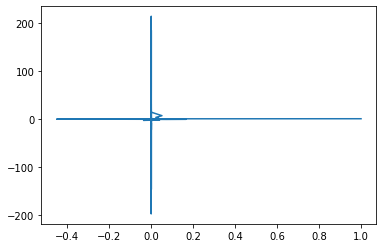

In [38]:
g = lambda x, y : np.array([1,1])
y0 = [1,1]
t = np.arange(0, 100)

U = brownian_motion(g, y0, t)
X = t

plt.plot(U[:,0], U[:,1])
plt.show()

# animate(X, U, "Random Walk w/ Brownian Motion")

In [45]:
# Problem 2
def euler_maruyama(f,g,y0,t):
    """
    Use the Euler-Maruyama method to predict
    the future n observations of the SDE
        dS = S\mu(t)dt + S\sigma(t)dW

    Parameters:
        f (function): number of future observations
        g (function): mu of dS/S
        sigma (float): sigma of dS/S
        y0 (ndnarray (mx1) or float or int): initial data point

    Returns:
       sol (ndarray (m,n)): future observations
    """
    # Initialize empty solution array
    sol = np.zeros((len(t), len(y0)))
    # Set the first element of solution
    sol[0] = y0
    # Calculate dt
    dt = t[1] - t[0]
    
    for i in range(1, len(t-1)):
        # Set up dW matrix
        dW = np.diag(np.random.normal(0, dt, len(y0)))
        # Compute next step
        sol[i] = sol[i-1] + f(t, sol[i-1]) * sol[i-1] * dt + g(i, sol[i-1]) * sol[i-1] @ dW
    return sol

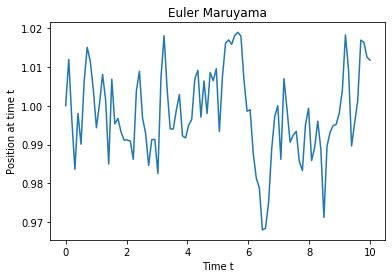

In [48]:
f = lambda t, S_t: 1 - S_t**2
g = lambda t, S_t: 0.1
y0 = np.array([1])
t = np.linspace(0, 10, 100)

sol = euler_maruyama(f, g, y0, t)
X = t

plt.plot(t, sol[:,0])
plt.title("Euler Maruyama")
plt.xlabel("Time t")
plt.ylabel("Position at time t")
plt.show()

# animate(X, sol, "Random Walk w/ Brownian Motion")

In [89]:
# Problem 3
def theta(data):
    """
    Calculate MAP of mu and sigma.

    Parameters:
        data (str): filename of historical data
    
    Returns:
        mu (ndarray): mean of data
        sigma (ndarray): standard deviation of data
    """
    df = pd.read_csv(data)
    closing_vals = df.close
    sample_mean = closing_vals.mean()
    sample_var = closing_vals.var(ddof=0)
    
    N = len(closing_vals)
    S = closing_vals
    
    def f(inp):
        mu, sigma = inp
        
        sum_ = np.sum([((S[i] - S[i-1])/S[i] - mu)**2 for i in range(1, N)])
        
        return N * np.log(np.sqrt(2*np.pi*sigma**2)) + 1/(2*sigma**2) * sum_
    
    return minimize(f, (sample_mean, sample_var), method='Nelder-Mead')

In [90]:
sol = theta("google_stock.csv")
mu, sigma = sol.x
print(mu, sigma)

-0.0001501904321586187 0.017118361705164016


In [161]:
# Problem 4
def prob4(iters=1000):
    """
    Use the Euler-Maruyama method on historical Google stock data.
    Run the method 1000 times and plot the average predict stock value
    for the next n values

    Parameters:
        n (int): number of predicted values
        iterations (int): number of iterations
    """
    f = lambda t, S_t : mu
    g = lambda t, S_t : sigma
    df = pd.read_csv("google_stock.csv")
    closing_vals = df.close
    y0 = np.array([closing_vals.values[-1]])
    t = np.arange(377, 427)
    
    sols = np.zeros((iters, len(t)))
    for i in range(iters):
        sols[i] = euler_maruyama(f, g, y0, t).squeeze()
    
    return sols.mean(axis=0)

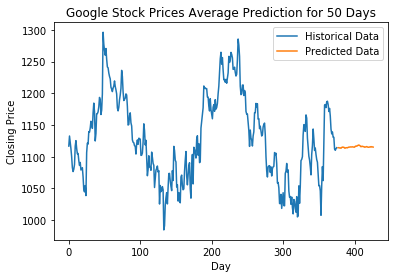

In [164]:
sol = prob4()

df = pd.read_csv("google_stock.csv")
closing_vals = df.close.values

plt.plot(np.arange(376), closing_vals, label="Historical Data")
plt.plot(np.arange(377, 427), sol, label="Predicted Data")
plt.legend()
plt.title("Google Stock Prices Average Prediction for 50 Days")
plt.xlabel("Day")
plt.ylabel("Closing Price")
plt.show()

In [179]:
def exact_sol(mu, sigma, y0, t):
    sol = np.zeros((len(t), len(y0)))
    sol[0] = y0
    for i in range(1, len(t-1)):
        rand = np.random.normal(mu, sigma**2, 1)
        sol[i] = y0 * np.exp((mu - sigma**2/2) * i + sigma * rand)
    
    return sol

In [190]:
def convergence(iters = 1000):
    """
    Show convergence of EM
    
    Parameters:
        iters (int): number of times to calculate difference
    """
    f = lambda t, S_t : mu
    g = lambda t, S_t : sigma
    for j in range(6):
        dt = 2**j
        differences = np.zeros((iters, len(t)))
        t = np.arange(376, 427)
        y0 = np.array([closing_vals[0]])
        for i in range(iters):
            approx = euler_maruyama(f, g, y0, t)
            exact = exact_sol(mu, sigma, y0, t)
            differences[i] = exact - approx

        difference = differences.mean(axis=0)
    
    return differences

In [191]:
errors = convergence()

[[1116.79      ]
 [1116.44690163]
 [1116.13265743]
 [1115.78294971]
 [1115.46200245]
 [1115.13613132]
 [1114.79698837]
 [1114.46198063]
 [1114.13173376]
 [1113.80942921]
 [1113.4702089 ]
 [1113.14865801]
 [1112.81989447]
 [1112.49697132]
 [1112.16138328]
 [1111.82703363]
 [1111.49122156]
 [1111.16987502]
 [1110.84976186]
 [1110.51338109]
 [1110.17602679]
 [1109.84954337]
 [1109.52665435]
 [1109.18702051]
 [1108.863216  ]
 [1108.53005975]
 [1108.20017884]
 [1107.87500503]
 [1107.54866334]
 [1107.21914037]
 [1106.8803081 ]
 [1106.55303281]
 [1106.24241779]
 [1105.91166459]
 [1105.57049928]
 [1105.26142939]
 [1104.91881568]
 [1104.59503539]
 [1104.26485024]
 [1103.93160853]
 [1103.60846334]
 [1103.2837667 ]
 [1102.95322831]
 [1102.62969007]
 [1102.3005089 ]
 [1101.97074361]
 [1101.64335512]
 [1101.31613041]
 [1101.00251108]
 [1100.67090319]
 [1100.34315615]]
[[1116.79      ]
 [1116.45260358]
 [1116.11391607]
 [1115.79776965]
 [1115.46803784]
 [1115.12560376]
 [1114.80130047]
 [1114.475162

[[1116.79      ]
 [1116.44588102]
 [1116.12422428]
 [1115.80145824]
 [1115.46625424]
 [1115.1202858 ]
 [1114.80141461]
 [1114.47927245]
 [1114.1379851 ]
 [1113.80850026]
 [1113.48071684]
 [1113.14661862]
 [1112.82593535]
 [1112.49633401]
 [1112.16334712]
 [1111.83083468]
 [1111.50790977]
 [1111.1724621 ]
 [1110.84226514]
 [1110.50486868]
 [1110.17514615]
 [1109.85315139]
 [1109.52561815]
 [1109.18892349]
 [1108.86197153]
 [1108.52509443]
 [1108.20265577]
 [1107.87134989]
 [1107.54561572]
 [1107.21494468]
 [1106.8905442 ]
 [1106.56081948]
 [1106.23428255]
 [1105.8996209 ]
 [1105.58412066]
 [1105.25028755]
 [1104.92257844]
 [1104.59371149]
 [1104.26134555]
 [1103.94011538]
 [1103.61220739]
 [1103.27638725]
 [1102.96114587]
 [1102.62624534]
 [1102.3010858 ]
 [1101.9697066 ]
 [1101.64742139]
 [1101.32880954]
 [1100.99574689]
 [1100.66438898]
 [1100.34113977]]
[[1116.79      ]
 [1116.45089436]
 [1116.1327402 ]
 [1115.79743532]
 [1115.46951758]
 [1115.13640209]
 [1114.80092793]
 [1114.471584

 [1100.3440923 ]]
[[1116.79      ]
 [1116.45686271]
 [1116.12830934]
 [1115.78293686]
 [1115.46271284]
 [1115.13652276]
 [1114.80334226]
 [1114.47594007]
 [1114.13386609]
 [1113.81380485]
 [1113.47717028]
 [1113.1534942 ]
 [1112.80887789]
 [1112.48830639]
 [1112.15986182]
 [1111.82440224]
 [1111.49601131]
 [1111.16819923]
 [1110.84186145]
 [1110.49629414]
 [1110.18027823]
 [1109.85531914]
 [1109.52460909]
 [1109.19208724]
 [1108.86394239]
 [1108.53392842]
 [1108.20135253]
 [1107.86983745]
 [1107.55596118]
 [1107.22793241]
 [1106.88852026]
 [1106.55259327]
 [1106.24059307]
 [1105.91231554]
 [1105.57021069]
 [1105.24635561]
 [1104.92290133]
 [1104.58863519]
 [1104.26365676]
 [1103.93908272]
 [1103.6004953 ]
 [1103.27529345]
 [1102.96060239]
 [1102.63034454]
 [1102.29674336]
 [1101.9747699 ]
 [1101.64414525]
 [1101.31560066]
 [1100.99592782]
 [1100.65877786]
 [1100.34872555]]
[[1116.79      ]
 [1116.45302874]
 [1116.1233234 ]
 [1115.79886459]
 [1115.46917557]
 [1115.12608486]
 [1114.79945

 [1100.35080728]]
[[1116.79      ]
 [1116.45394125]
 [1116.11840492]
 [1115.79918462]
 [1115.46133022]
 [1115.13581067]
 [1114.79932744]
 [1114.4728111 ]
 [1114.13399128]
 [1113.80926396]
 [1113.48266949]
 [1113.1382596 ]
 [1112.80654219]
 [1112.49195237]
 [1112.1559561 ]
 [1111.82978756]
 [1111.49759101]
 [1111.16868718]
 [1110.83152139]
 [1110.5080968 ]
 [1110.17669114]
 [1109.8577227 ]
 [1109.50587304]
 [1109.19485747]
 [1108.86000291]
 [1108.52903361]
 [1108.1965185 ]
 [1107.86611777]
 [1107.5408232 ]
 [1107.2222019 ]
 [1106.88532   ]
 [1106.55906069]
 [1106.23422985]
 [1105.89850084]
 [1105.58435407]
 [1105.25597624]
 [1104.92672378]
 [1104.59853316]
 [1104.27235353]
 [1103.93677279]
 [1103.60520659]
 [1103.28841283]
 [1102.96079267]
 [1102.62790677]
 [1102.3021219 ]
 [1101.97229136]
 [1101.64695453]
 [1101.32386627]
 [1101.0068856 ]
 [1100.67105732]
 [1100.35220354]]
[[1116.79      ]
 [1116.45351063]
 [1116.13014189]
 [1115.79874885]
 [1115.46565978]
 [1115.13284569]
 [1114.81393

 [1100.35012849]]
[[1116.79      ]
 [1116.45425832]
 [1116.11930647]
 [1115.79195635]
 [1115.45504974]
 [1115.1406936 ]
 [1114.80277772]
 [1114.46888371]
 [1114.13833225]
 [1113.80160033]
 [1113.48438159]
 [1113.15558783]
 [1112.82743493]
 [1112.49530304]
 [1112.1599663 ]
 [1111.81988121]
 [1111.49198671]
 [1111.17441269]
 [1110.84466266]
 [1110.51307625]
 [1110.17641733]
 [1109.84024419]
 [1109.51290421]
 [1109.19037522]
 [1108.85575634]
 [1108.54126886]
 [1108.20866758]
 [1107.88256143]
 [1107.54894722]
 [1107.21731917]
 [1106.89843739]
 [1106.56168388]
 [1106.2425819 ]
 [1105.90320653]
 [1105.58164301]
 [1105.2520572 ]
 [1104.92690353]
 [1104.59323995]
 [1104.26217356]
 [1103.94553526]
 [1103.61843569]
 [1103.28868295]
 [1102.96199866]
 [1102.63486966]
 [1102.297065  ]
 [1101.97792837]
 [1101.64643818]
 [1101.3261474 ]
 [1100.98828755]
 [1100.67299374]
 [1100.35021035]]
[[1116.79      ]
 [1116.45381757]
 [1116.12348687]
 [1115.78589508]
 [1115.45901532]
 [1115.13737953]
 [1114.78993

 [1100.34327309]]
[[1116.79      ]
 [1116.45957988]
 [1116.12232462]
 [1115.80883534]
 [1115.46524337]
 [1115.13418636]
 [1114.80375552]
 [1114.47384169]
 [1114.13920815]
 [1113.8083093 ]
 [1113.47629798]
 [1113.14277614]
 [1112.819553  ]
 [1112.49069625]
 [1112.15117473]
 [1111.82614376]
 [1111.49608591]
 [1111.17055413]
 [1110.84436844]
 [1110.51416619]
 [1110.17289425]
 [1109.84777057]
 [1109.51843546]
 [1109.18951968]
 [1108.8640642 ]
 [1108.52744134]
 [1108.21385181]
 [1107.86986152]
 [1107.55139952]
 [1107.22874295]
 [1106.89565462]
 [1106.56667943]
 [1106.22773775]
 [1105.91378043]
 [1105.57919407]
 [1105.24942696]
 [1104.9228257 ]
 [1104.59802887]
 [1104.25286786]
 [1103.94044916]
 [1103.60868279]
 [1103.28772142]
 [1102.96496879]
 [1102.62464277]
 [1102.30331189]
 [1101.98420498]
 [1101.63884436]
 [1101.3161251 ]
 [1100.9871127 ]
 [1100.66191243]
 [1100.33667866]]
[[1116.79      ]
 [1116.4533789 ]
 [1116.13253037]
 [1115.79747131]
 [1115.46717024]
 [1115.13113105]
 [1114.80311

 [1100.34194763]]
[[1116.79      ]
 [1116.46038748]
 [1116.12379792]
 [1115.79182291]
 [1115.45768642]
 [1115.12777152]
 [1114.80049799]
 [1114.47660557]
 [1114.13674175]
 [1113.80752486]
 [1113.48565223]
 [1113.15324734]
 [1112.80556453]
 [1112.48468609]
 [1112.14268517]
 [1111.83240428]
 [1111.49464462]
 [1111.1733049 ]
 [1110.84886931]
 [1110.51501876]
 [1110.17797432]
 [1109.85402938]
 [1109.5327748 ]
 [1109.19489463]
 [1108.85969711]
 [1108.54156458]
 [1108.20662026]
 [1107.8811834 ]
 [1107.55224894]
 [1107.2297189 ]
 [1106.88466838]
 [1106.56807652]
 [1106.22951644]
 [1105.90384665]
 [1105.58390699]
 [1105.25741357]
 [1104.93019534]
 [1104.58916781]
 [1104.26576402]
 [1103.94110219]
 [1103.6106279 ]
 [1103.28093567]
 [1102.96131831]
 [1102.63438266]
 [1102.29497223]
 [1101.97093854]
 [1101.64965028]
 [1101.3266029 ]
 [1101.00114924]
 [1100.66982115]
 [1100.34012666]]
[[1116.79      ]
 [1116.45460359]
 [1116.11511462]
 [1115.80882668]
 [1115.47241245]
 [1115.13836364]
 [1114.79522

 [1100.34145804]]
[[1116.79      ]
 [1116.45616488]
 [1116.12377539]
 [1115.78070532]
 [1115.46210947]
 [1115.13139536]
 [1114.80418241]
 [1114.46533208]
 [1114.13652145]
 [1113.8115124 ]
 [1113.47855912]
 [1113.15523081]
 [1112.81251246]
 [1112.48643877]
 [1112.15836173]
 [1111.83689634]
 [1111.50329475]
 [1111.16679057]
 [1110.83775724]
 [1110.51015266]
 [1110.17914927]
 [1109.83352716]
 [1109.5271519 ]
 [1109.19620653]
 [1108.86770971]
 [1108.52633735]
 [1108.2070173 ]
 [1107.87481059]
 [1107.54879965]
 [1107.22137339]
 [1106.88733719]
 [1106.56436753]
 [1106.2385877 ]
 [1105.90485283]
 [1105.57965288]
 [1105.24375498]
 [1104.92985604]
 [1104.5882862 ]
 [1104.27421273]
 [1103.93193338]
 [1103.6079134 ]
 [1103.26898603]
 [1102.94562256]
 [1102.61392178]
 [1102.30379329]
 [1101.97497079]
 [1101.64985346]
 [1101.32017874]
 [1100.99291983]
 [1100.66553315]
 [1100.34111706]]
[[1116.79      ]
 [1116.45988254]
 [1116.12012311]
 [1115.79191628]
 [1115.45416353]
 [1115.13009828]
 [1114.79985

 [1100.33506154]]
[[1116.79      ]
 [1116.45554759]
 [1116.12494103]
 [1115.79129526]
 [1115.4549865 ]
 [1115.12517987]
 [1114.79966153]
 [1114.46326146]
 [1114.13929377]
 [1113.81233372]
 [1113.46988519]
 [1113.15882982]
 [1112.82448504]
 [1112.49332933]
 [1112.15894441]
 [1111.8299343 ]
 [1111.49408766]
 [1111.17418535]
 [1110.84569381]
 [1110.51018941]
 [1110.18583738]
 [1109.84421457]
 [1109.51980387]
 [1109.1869742 ]
 [1108.87020901]
 [1108.53180052]
 [1108.20434035]
 [1107.87703584]
 [1107.54508726]
 [1107.22167936]
 [1106.89158378]
 [1106.56395908]
 [1106.22683317]
 [1105.90476187]
 [1105.57553904]
 [1105.24186755]
 [1104.9138905 ]
 [1104.58989712]
 [1104.25951632]
 [1103.93506516]
 [1103.59869495]
 [1103.28880928]
 [1102.95511363]
 [1102.63467534]
 [1102.30697092]
 [1101.9761134 ]
 [1101.64988279]
 [1101.32644712]
 [1100.99409924]
 [1100.67787178]
 [1100.34564648]]
[[1116.79      ]
 [1116.46000015]
 [1116.12641357]
 [1115.79257047]
 [1115.46254012]
 [1115.12009092]
 [1114.80384

 [1100.34030942]]
[[1116.79      ]
 [1116.45780462]
 [1116.11812693]
 [1115.80159214]
 [1115.47007993]
 [1115.12221116]
 [1114.80151364]
 [1114.472397  ]
 [1114.13378452]
 [1113.81602154]
 [1113.4759805 ]
 [1113.15430606]
 [1112.81779429]
 [1112.48950682]
 [1112.15163954]
 [1111.8233279 ]
 [1111.4972443 ]
 [1111.16276884]
 [1110.83989138]
 [1110.51023279]
 [1110.18763932]
 [1109.84282416]
 [1109.524548  ]
 [1109.19713182]
 [1108.86951349]
 [1108.53778521]
 [1108.19059243]
 [1107.86695223]
 [1107.55117242]
 [1107.21514567]
 [1106.892903  ]
 [1106.56437854]
 [1106.23460478]
 [1105.89461658]
 [1105.56978545]
 [1105.25111049]
 [1104.91815489]
 [1104.58742648]
 [1104.26383259]
 [1103.93626026]
 [1103.60525784]
 [1103.28253318]
 [1102.94870634]
 [1102.62764557]
 [1102.30570259]
 [1101.97504154]
 [1101.64791897]
 [1101.3114472 ]
 [1100.99110663]
 [1100.66556406]
 [1100.34483555]]
[[1116.79      ]
 [1116.44918253]
 [1116.13037746]
 [1115.80149538]
 [1115.46545104]
 [1115.13301818]
 [1114.80902

 [1100.3366113 ]]
[[1116.79      ]
 [1116.47024204]
 [1116.13485726]
 [1115.80081883]
 [1115.45805331]
 [1115.12896482]
 [1114.80323029]
 [1114.46335072]
 [1114.14464182]
 [1113.80154629]
 [1113.47628872]
 [1113.1455463 ]
 [1112.8212344 ]
 [1112.48856083]
 [1112.16397032]
 [1111.82751084]
 [1111.50065638]
 [1111.16844645]
 [1110.83536774]
 [1110.50480085]
 [1110.18243021]
 [1109.85085017]
 [1109.51518256]
 [1109.19336282]
 [1108.86259163]
 [1108.53627003]
 [1108.21547314]
 [1107.87242872]
 [1107.5487331 ]
 [1107.21589304]
 [1106.89142123]
 [1106.56236289]
 [1106.22840017]
 [1105.9122962 ]
 [1105.57604226]
 [1105.25868715]
 [1104.9225456 ]
 [1104.5940613 ]
 [1104.25766154]
 [1103.93734374]
 [1103.61393056]
 [1103.28542106]
 [1102.95887207]
 [1102.62968524]
 [1102.30793664]
 [1101.97830825]
 [1101.65842237]
 [1101.32584334]
 [1101.00471552]
 [1100.66326713]
 [1100.34551664]]
[[1116.79      ]
 [1116.45496348]
 [1116.13056869]
 [1115.78763059]
 [1115.46711779]
 [1115.12568176]
 [1114.81623

 [1100.3325883 ]]
[[1116.79      ]
 [1116.46140798]
 [1116.11716213]
 [1115.79382807]
 [1115.46936259]
 [1115.13517449]
 [1114.80118692]
 [1114.47765951]
 [1114.1416236 ]
 [1113.80509894]
 [1113.48171978]
 [1113.15768755]
 [1112.82220021]
 [1112.49061527]
 [1112.15308723]
 [1111.82469374]
 [1111.49549865]
 [1111.16494943]
 [1110.84191924]
 [1110.50706426]
 [1110.18361444]
 [1109.8509212 ]
 [1109.52140334]
 [1109.18621495]
 [1108.85908713]
 [1108.52851123]
 [1108.20676651]
 [1107.87482407]
 [1107.53954283]
 [1107.21828544]
 [1106.8808292 ]
 [1106.55983816]
 [1106.23162472]
 [1105.90119478]
 [1105.58164287]
 [1105.25433344]
 [1104.92150532]
 [1104.59790141]
 [1104.26526447]
 [1103.9341502 ]
 [1103.61788735]
 [1103.27821815]
 [1102.95522511]
 [1102.61885548]
 [1102.30042675]
 [1101.97867583]
 [1101.65977351]
 [1101.31677644]
 [1100.99396269]
 [1100.6679336 ]
 [1100.34572479]]
[[1116.79      ]
 [1116.44625317]
 [1116.11962118]
 [1115.78285709]
 [1115.4631569 ]
 [1115.13252328]
 [1114.80753

 [1100.33574377]]
[[1116.79      ]
 [1116.45997055]
 [1116.1235487 ]
 [1115.79867148]
 [1115.4594816 ]
 [1115.1287549 ]
 [1114.79757502]
 [1114.47990869]
 [1114.13841667]
 [1113.80610668]
 [1113.48510626]
 [1113.15274948]
 [1112.82224613]
 [1112.49246558]
 [1112.16348537]
 [1111.82593718]
 [1111.49473308]
 [1111.16481698]
 [1110.83204716]
 [1110.51618189]
 [1110.17969003]
 [1109.84974806]
 [1109.5230531 ]
 [1109.18995667]
 [1108.86009127]
 [1108.53032329]
 [1108.20642612]
 [1107.88372321]
 [1107.5470111 ]
 [1107.22323239]
 [1106.88802418]
 [1106.56312982]
 [1106.23857552]
 [1105.91127165]
 [1105.56310049]
 [1105.25605111]
 [1104.93034106]
 [1104.59146796]
 [1104.26842184]
 [1103.94459362]
 [1103.62043564]
 [1103.28671783]
 [1102.95858709]
 [1102.62687566]
 [1102.31548922]
 [1101.97743356]
 [1101.64762837]
 [1101.31660412]
 [1100.99280325]
 [1100.66256615]
 [1100.34476   ]]
[[1116.79      ]
 [1116.45295482]
 [1116.12423819]
 [1115.79380921]
 [1115.45950844]
 [1115.13298014]
 [1114.80531

 [1100.33682297]]
[[1116.79      ]
 [1116.44878638]
 [1116.13144919]
 [1115.79612825]
 [1115.46304357]
 [1115.13173134]
 [1114.79317192]
 [1114.47019459]
 [1114.13008349]
 [1113.80954523]
 [1113.47872143]
 [1113.14734638]
 [1112.82273412]
 [1112.49386005]
 [1112.16118544]
 [1111.82316924]
 [1111.50229071]
 [1111.16317257]
 [1110.83045281]
 [1110.51630401]
 [1110.18603264]
 [1109.85842749]
 [1109.52191095]
 [1109.19171705]
 [1108.85793924]
 [1108.53185872]
 [1108.20701071]
 [1107.8740003 ]
 [1107.54323446]
 [1107.21841879]
 [1106.89571837]
 [1106.56319917]
 [1106.22428306]
 [1105.91942672]
 [1105.57003416]
 [1105.25950828]
 [1104.92083052]
 [1104.60881248]
 [1104.26187491]
 [1103.94403159]
 [1103.60173164]
 [1103.27991717]
 [1102.9487917 ]
 [1102.62500964]
 [1102.29548256]
 [1101.97504366]
 [1101.64794298]
 [1101.32074154]
 [1100.99705533]
 [1100.65887806]
 [1100.3409555 ]]
[[1116.79      ]
 [1116.45733293]
 [1116.11949369]
 [1115.79938515]
 [1115.47117681]
 [1115.12742858]
 [1114.78665

[[1116.79      ]
 [1116.45531444]
 [1116.12748287]
 [1115.80003701]
 [1115.47261661]
 [1115.13654234]
 [1114.81073773]
 [1114.47736981]
 [1114.14021836]
 [1113.81444065]
 [1113.48222336]
 [1113.1423835 ]
 [1112.82858328]
 [1112.49270324]
 [1112.16944468]
 [1111.82319459]
 [1111.50674601]
 [1111.17681734]
 [1110.83766325]
 [1110.51033639]
 [1110.16256365]
 [1109.85592375]
 [1109.52728207]
 [1109.19703414]
 [1108.86433496]
 [1108.53706223]
 [1108.20882356]
 [1107.88313018]
 [1107.54839025]
 [1107.21420668]
 [1106.88237704]
 [1106.5578116 ]
 [1106.23726098]
 [1105.91064878]
 [1105.57513582]
 [1105.25450158]
 [1104.92905231]
 [1104.59066001]
 [1104.27429702]
 [1103.93336669]
 [1103.61852394]
 [1103.28968361]
 [1102.96589502]
 [1102.64339754]
 [1102.30243396]
 [1101.9656446 ]
 [1101.65057967]
 [1101.32743114]
 [1100.98685437]
 [1100.66632606]
 [1100.34713178]]
[[1116.79      ]
 [1116.45901176]
 [1116.13084356]
 [1115.79708133]
 [1115.46381701]
 [1115.12684718]
 [1114.80157531]
 [1114.466325

 [1100.33937808]]
[[1116.79      ]
 [1116.45607175]
 [1116.11832779]
 [1115.79797119]
 [1115.46481895]
 [1115.13786615]
 [1114.80822996]
 [1114.471162  ]
 [1114.13734891]
 [1113.8071587 ]
 [1113.47583043]
 [1113.1466519 ]
 [1112.81097569]
 [1112.49457591]
 [1112.15410906]
 [1111.81813841]
 [1111.49613476]
 [1111.16468602]
 [1110.83632194]
 [1110.52264491]
 [1110.17740959]
 [1109.85249366]
 [1109.53036854]
 [1109.18202583]
 [1108.85997222]
 [1108.53690594]
 [1108.20215295]
 [1107.87779302]
 [1107.53923915]
 [1107.22006258]
 [1106.89488914]
 [1106.56469704]
 [1106.22663557]
 [1105.9049886 ]
 [1105.5784284 ]
 [1105.26027166]
 [1104.91868848]
 [1104.58167923]
 [1104.2612424 ]
 [1103.93800752]
 [1103.60102487]
 [1103.27702474]
 [1102.96228415]
 [1102.63720312]
 [1102.30316669]
 [1101.9828652 ]
 [1101.64659047]
 [1101.31859005]
 [1100.99267508]
 [1100.66396674]
 [1100.34232175]]
[[1116.79      ]
 [1116.4463368 ]
 [1116.11201765]
 [1115.79849549]
 [1115.46055177]
 [1115.13918837]
 [1114.79636

[[1116.79      ]
 [1116.45315804]
 [1116.12559832]
 [1115.79567084]
 [1115.45912495]
 [1115.13119317]
 [1114.80306561]
 [1114.46041188]
 [1114.14093728]
 [1113.8086466 ]
 [1113.47939796]
 [1113.14962943]
 [1112.82472966]
 [1112.48700491]
 [1112.16197109]
 [1111.8286969 ]
 [1111.50113797]
 [1111.16119269]
 [1110.84292157]
 [1110.50701504]
 [1110.17811739]
 [1109.85580944]
 [1109.52017753]
 [1109.18814946]
 [1108.86100705]
 [1108.54045983]
 [1108.20132932]
 [1107.87801357]
 [1107.54201281]
 [1107.2159221 ]
 [1106.88744197]
 [1106.56040016]
 [1106.23785597]
 [1105.90481889]
 [1105.56323893]
 [1105.24626539]
 [1104.91851155]
 [1104.5972478 ]
 [1104.27213992]
 [1103.93638948]
 [1103.61588013]
 [1103.28543061]
 [1102.95128332]
 [1102.63828764]
 [1102.30088821]
 [1101.98625648]
 [1101.64797722]
 [1101.31546891]
 [1100.98896895]
 [1100.66985861]
 [1100.34154184]]
[[1116.79      ]
 [1116.44755202]
 [1116.12884247]
 [1115.79257691]
 [1115.4618333 ]
 [1115.12655611]
 [1114.79892042]
 [1114.458035

 [1100.34417135]]
[[1116.79      ]
 [1116.46031771]
 [1116.10899699]
 [1115.79355209]
 [1115.46318858]
 [1115.13721174]
 [1114.8015748 ]
 [1114.46648714]
 [1114.14284284]
 [1113.80916391]
 [1113.47534034]
 [1113.15110785]
 [1112.8130716 ]
 [1112.48840493]
 [1112.16497941]
 [1111.82059058]
 [1111.49951459]
 [1111.1738646 ]
 [1110.82542618]
 [1110.51501877]
 [1110.1938447 ]
 [1109.84656782]
 [1109.52440842]
 [1109.1941072 ]
 [1108.86799004]
 [1108.52796531]
 [1108.19167711]
 [1107.87793924]
 [1107.55818955]
 [1107.21521598]
 [1106.89212317]
 [1106.560312  ]
 [1106.23194405]
 [1105.90019691]
 [1105.56689481]
 [1105.24750542]
 [1104.92033856]
 [1104.59506639]
 [1104.26014085]
 [1103.93984822]
 [1103.61773192]
 [1103.28108421]
 [1102.95161268]
 [1102.62716546]
 [1102.30052917]
 [1101.97473088]
 [1101.65286666]
 [1101.32880327]
 [1100.99843562]
 [1100.65892628]
 [1100.3342092 ]]
[[1116.79      ]
 [1116.45616728]
 [1116.12592957]
 [1115.78444515]
 [1115.46923472]
 [1115.12359823]
 [1114.79356

 [1100.34305486]]
[[1116.79      ]
 [1116.46067433]
 [1116.12170358]
 [1115.78288135]
 [1115.46703677]
 [1115.13529381]
 [1114.80150968]
 [1114.46503038]
 [1114.14256795]
 [1113.81001348]
 [1113.4733738 ]
 [1113.1405682 ]
 [1112.81697112]
 [1112.48208563]
 [1112.15534872]
 [1111.82844879]
 [1111.50502381]
 [1111.15795687]
 [1110.83836039]
 [1110.49738058]
 [1110.18699607]
 [1109.84609258]
 [1109.52588027]
 [1109.19576744]
 [1108.86116449]
 [1108.52752237]
 [1108.19919788]
 [1107.87184845]
 [1107.54625113]
 [1107.21746953]
 [1106.89277344]
 [1106.55056097]
 [1106.23174266]
 [1105.90359906]
 [1105.57254845]
 [1105.24695601]
 [1104.92675893]
 [1104.59471796]
 [1104.26735247]
 [1103.92823072]
 [1103.60939237]
 [1103.28565801]
 [1102.95796618]
 [1102.63137025]
 [1102.30677162]
 [1101.97402323]
 [1101.64738012]
 [1101.31671604]
 [1100.99393635]
 [1100.66446029]
 [1100.34257785]]
[[1116.79      ]
 [1116.45577271]
 [1116.12410338]
 [1115.78779674]
 [1115.45635383]
 [1115.12408847]
 [1114.79601

 [1100.33050751]]
[[1116.79      ]
 [1116.45749254]
 [1116.12800561]
 [1115.79626154]
 [1115.46830749]
 [1115.12671894]
 [1114.8012663 ]
 [1114.46423801]
 [1114.14477472]
 [1113.80926209]
 [1113.48406282]
 [1113.14822176]
 [1112.82057271]
 [1112.48992262]
 [1112.14565163]
 [1111.83637611]
 [1111.49987364]
 [1111.16124314]
 [1110.84025128]
 [1110.51093242]
 [1110.18132615]
 [1109.85075356]
 [1109.50797535]
 [1109.17832092]
 [1108.85855144]
 [1108.53380318]
 [1108.21121315]
 [1107.87792438]
 [1107.54661749]
 [1107.21886767]
 [1106.89854179]
 [1106.55199163]
 [1106.22629962]
 [1105.90996122]
 [1105.56633219]
 [1105.25157142]
 [1104.91607512]
 [1104.59079724]
 [1104.26295794]
 [1103.93382524]
 [1103.61484914]
 [1103.28343786]
 [1102.95974135]
 [1102.62582372]
 [1102.3025489 ]
 [1101.97486434]
 [1101.64612388]
 [1101.33389215]
 [1100.99922866]
 [1100.66495466]
 [1100.34636829]]
[[1116.79      ]
 [1116.46260363]
 [1116.12184236]
 [1115.79061084]
 [1115.45914283]
 [1115.13957938]
 [1114.79580

 [1100.33524421]]
[[1116.79      ]
 [1116.45576684]
 [1116.1211845 ]
 [1115.7824724 ]
 [1115.46187239]
 [1115.13494495]
 [1114.78977121]
 [1114.47313035]
 [1114.13740519]
 [1113.80859312]
 [1113.471646  ]
 [1113.14805571]
 [1112.82306509]
 [1112.48357146]
 [1112.16782214]
 [1111.82911607]
 [1111.50314789]
 [1111.16439639]
 [1110.84669287]
 [1110.50575275]
 [1110.18418749]
 [1109.8638887 ]
 [1109.52066074]
 [1109.19529671]
 [1108.85572422]
 [1108.53495887]
 [1108.20619754]
 [1107.87330944]
 [1107.54348773]
 [1107.20891448]
 [1106.88683448]
 [1106.56039889]
 [1106.22976437]
 [1105.90272596]
 [1105.57358264]
 [1105.25244298]
 [1104.92517695]
 [1104.59189357]
 [1104.27605028]
 [1103.94648026]
 [1103.61599342]
 [1103.28167341]
 [1102.94659685]
 [1102.63439012]
 [1102.30597836]
 [1101.96893723]
 [1101.65140795]
 [1101.31940288]
 [1100.99102285]
 [1100.66878885]
 [1100.34346683]]
[[1116.79      ]
 [1116.45985058]
 [1116.12733031]
 [1115.78891677]
 [1115.46086287]
 [1115.13313631]
 [1114.79802

 [1100.35187782]]
[[1116.79      ]
 [1116.45549737]
 [1116.11973599]
 [1115.78694429]
 [1115.47180167]
 [1115.12807381]
 [1114.80973837]
 [1114.47106859]
 [1114.14621792]
 [1113.81339341]
 [1113.47598919]
 [1113.15129931]
 [1112.81604014]
 [1112.48637671]
 [1112.1617614 ]
 [1111.83422472]
 [1111.5017755 ]
 [1111.16019685]
 [1110.83818545]
 [1110.51462662]
 [1110.18789038]
 [1109.84438931]
 [1109.51836143]
 [1109.19027966]
 [1108.86409265]
 [1108.52346968]
 [1108.20952879]
 [1107.87515216]
 [1107.55153663]
 [1107.21436939]
 [1106.89355907]
 [1106.55745093]
 [1106.22791493]
 [1105.90603536]
 [1105.57485412]
 [1105.24655041]
 [1104.92039269]
 [1104.59752254]
 [1104.26749068]
 [1103.92567705]
 [1103.60451231]
 [1103.28550582]
 [1102.95919569]
 [1102.6208862 ]
 [1102.30200001]
 [1101.98417817]
 [1101.64513427]
 [1101.3145246 ]
 [1100.99401549]
 [1100.66587434]
 [1100.33384432]]
[[1116.79      ]
 [1116.45222586]
 [1116.11832056]
 [1115.79055216]
 [1115.46854347]
 [1115.1448852 ]
 [1114.80163

In [189]:
errors

[709.437097760008,
 533.0627483294645,
 180.41953192697832,
 991.6804950518591,
 1085.5213678567452,
 863.5409732329749,
 280.66152855549745,
 821.1741836463974,
 554.2580790804046,
 604.1263351714919,
 1342.4552948036321,
 358.54408579466457,
 577.1615134907298,
 924.1378140921292,
 1093.9439425837134,
 438.87735832887176,
 386.47237851407465,
 273.9909126023651,
 865.419040481776,
 594.7025735931161,
 403.7517637262531,
 422.7745480709461,
 1123.0452038306883,
 178.4360948071969,
 641.0313424167804,
 1160.8484131640707,
 178.48872597663745,
 462.71743177131714,
 985.9006786227308,
 481.46982931216934,
 457.68501061802544,
 732.8352262094844,
 617.0996849783947,
 811.776230813087,
 552.4119856389428,
 534.6948180153188,
 807.9050738250932,
 263.30044002997255,
 568.2256619004862,
 822.2612344292578,
 330.95707248148295,
 338.41426244993363,
 316.50491042702356,
 280.6220427901778,
 643.0758532959143,
 616.0468807335088,
 591.8964080396092,
 362.9559639164505,
 688.7776157702756,
 289.